In [1]:
import setGPU

import tensorflow as tf

import matplotlib.pyplot as plt
from random import shuffle
import os
import numpy as np
import cv2 as cv

setGPU: Setting GPU to: 0


/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3

In [2]:
train_data_path = '../data/sci_tvt/training'
validation_data_path = '../data/sci_tvt/validation'

In [3]:
def inference(inp_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=inp_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation = 'relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation = 'relu', name='conv4'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', name='conv5'))
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation = 'relu', name='conv6'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',  name='conv7'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation = 'relu', name='conv8'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation = 'relu', name='conv9'))
    model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation = 'relu', name='conv10'))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu', name='dense1'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(256, activation='relu', name='dense2'))
    model.add(tf.keras.layers.Dense(3, activation='softmax', name='final_class_dense'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['acc'] )
    
    return model

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                                               horizontal_flip=True, fill_mode='nearest')
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_path, target_size=(192, 192), batch_size=64, class_mode='categorical')
valid_generator = valid_datagen.flow_from_directory(validation_data_path, target_size=(192, 192), batch_size=64, class_mode='categorical')

input_shape = (192, 192, 3)
model = inference(input_shape)
print(model.summary())

train_samples_batch = train_generator.n//32
valid_samples_batch = valid_generator.n//32
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit_generator(train_generator, steps_per_epoch=train_samples_batch, epochs=500, validation_data=valid_generator, 
                              validation_steps=valid_samples_batch, callbacks=[es_callback])

model.save('../model/class_model.h5')

Found 4552 images belonging to 3 classes.
Found 1516 images belonging to 3 classes.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 192, 192, 32)      896       
_________________________________________________________________
conv2 (Conv2D)               (None, 192, 192, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 96, 96, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 96, 96, 64)        36928     
____________________________________________________

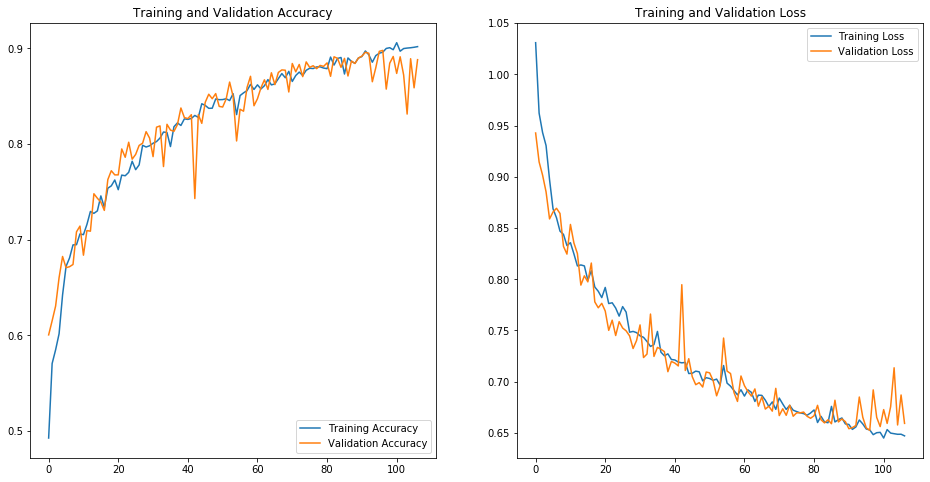

In [6]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(107)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [7]:
"""
https://towardsdatascience.com/image-classification-python-keras-tutorial-kaggle-challenge-45a6332a58b8
"""
def label_img(name):
    if name == 'FULL_VISIBILITY': return np.array([1, 0, 0])
    elif name == 'NO_VISIBILITY' : return np.array([0, 1, 0])
    elif name == 'PARTIAL_VISIBILITY': return np.array([0, 0, 1])

In [8]:
def load_test_data(path):
    test_data = []
    for clas in os.listdir(path):
        clas_path = os.path.join(path, clas)
        for file in os.listdir(clas_path):
            label = label_img(clas)
            
            file_path = os.path.join(clas_path, file)
            img = cv.imread(file_path)
            img = img*(1./255) #apply normalize that is applied in training
            test_data.append([np.array(img), label])
            
    shuffle(test_data)
    return test_data

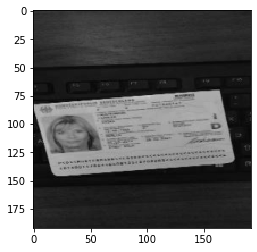

In [9]:
test_data_path = '../data/sci_tvt/test'
test_data = load_test_data(test_data_path)
plt.imshow(test_data[10][0], cmap = 'gist_gray')

In [100]:
testImages = np.array([i[0] for i in test_data])
testLabels = np.array([i[1] for i in test_data])

loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

87.07976341247559
